<a href="https://colab.research.google.com/github/DenisPerez/NN_Tests_DG/blob/main/Experimento1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento 1: Estudio de todos los métodos

**Propósito:** Estudiar el desempeño y la velocidad de convergencia basado en epochs de los métodos cíclicos y el método decreciente (propio) combinados con la estrategia de Momentum


> **Nota:** Si se utilizará Google Colab como ambiente para las pruebas, se debe tomar la referencia al repositorio para que la libreta tenga acceso a los archivos que requiere


In [133]:
# !git clone https://github.com/DenisPerez/NN_Tests_DG.git
# %cd NN_Tests_DG
# %ls

Al tener disponible los archivos a referenciar, se realizan las importaciones necesarias

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images
from classes import CyclicLRGiselt_Denis

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0) # => importante para replicar los experimentos. Setea la semilla para la generacion de numeros aleatorios

import random

### Extracción del conjunto de datos: MNIST

Este conjundo de datos esta basado en 60.000 imágenes en el conjunto de entrenamiento y 10.000 en el conjunto de prueba de 28x28 píxeles
que representan dígitos del 0 al 9 escritos a mano y es considerado el "Hola Mundo" en el
área de la ciencia de datos. Sin embargo, **10.000  de las muestras del conjunto de entrenamiento serán destinadas al conjunto de validación** con el que se te tomará la precisión en el entrenamiento.

In [135]:
MNIST_PATH = './Dataset/'

In [136]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [137]:
# Segmento para el conjunto de entrenamiento
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

# Segmento para el conjunto de validacion
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

# Segmento para el conjunto de prueba
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

### Normalización de la muestra

In [138]:
def normalize(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

Se toma la desviación estandar y la media de cada conjunto de datos y se llama a la función *normalize*

In [139]:
# Calculo para el conjunto de entrenamiento
x_mean = x_train.mean()
x_std = x_train.std()
x_train = normalize(x_mean, x_std, x_train)

# Calculo para el conjunto de validación
x_mean = x_val.mean()
x_std = x_val.std()
x_val = normalize(x_mean, x_std, x_val)

# Calculo para el conjunto de prueba
x_mean = x_test.mean()
x_std = x_test.std()
x_test = normalize(x_mean, x_std, x_test)

In [140]:
x_train.mean(), x_train.std()

(8.5686665e-08, 0.9999983)

### Visualización de la muestra

In [141]:
# Dimensiones del conjunto de datos de entrenamiento
x_test.shape

(10000, 784)

In [142]:
# Dimensiones del conjunto de datos de prueba:
y_train.shape

(50000, 1)

In [143]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 0


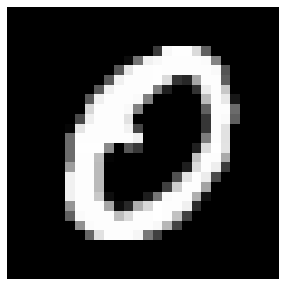

In [144]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Creación de mini lotes

In [145]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, input_layer
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

### Conversión de arreglo a tensores para todos los conjuntos de datos

In [146]:
# Conversion para el conjunto de entrenamiento
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

# Conversion para el conjunto de validación
x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

# Conversion para el conjunto de prueba
x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

### Habilitar el uso del CPU

Primero se consulta si se tiene la plataforma CUDA disponible para la utilización de los recursos de GPU

In [147]:
torch.cuda.is_available()

True

En caso de no tenerse, se asigna el trabajo de computo al CPU

In [148]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Funciones 

### Precisión

In [149]:
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total  

### Find LR

In [150]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, mb_size = 512):
    n = round(len(x_train_tensor) / mb_size)
    factor = (end_val / start_val)**(1/n)
    print(factor)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    i = 1
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):

        xi = xi.to(device = device, dtype = torch.float32)
        yi = yi.to(device = device, dtype = torch.long)
        scores = model(xi)
        cost = F.cross_entropy(input=scores, target=yi.squeeze())
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == yi).sum()/scores.size(0))
        acc = beta*acc + (1-beta)*acc_.item()
        avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
#         accuracies.append(acc.item())
        accuracies.append(avg_acc)
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        optimiser.zero_grad()
        cost.backward()
        optimiser.step()
        #update lr
        print(f'[{i}]cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        i += 1
        
    return log_lrs, losses, accuracies

### Entrenamiento

In [151]:
def train(model, optimizer, scheduler: None, mb_size):
    model = model.to(device=device)
    unregistered = True
    epoch_acc = 0.0
    iter_found = 0
    i = 0
    #plot lists
    acc_list = [0.0]
    cost_list = [0.0]
    lr_list = [0.0]
    while (i < 100):
        if (epoch_acc >= 0.95 and unregistered):
          iter_found = i
          unregistered = False
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            for name, param in model.named_parameters():
              ik = str(name)+'_'+str(i)
              prev_ik = str(name)+'_'+str(i-1)
            optimizer.step()
        if (scheduler != None):
          scheduler.step()
          lr = scheduler.get_last_lr()
          lr_list.append(lr[0])
        else: 
          lr = optimizer.param_groups[0]['lr']
          lr_list.append(lr)
        i+=1
        epoch_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        epoch_cost = cost.item()

        #append
        acc_list.append(epoch_acc)
        cost_list.append(epoch_cost)
        print(f'Epoch: {len(acc_list) - 1}, learning_rate:{lr},costo: {epoch_cost}, accuracy: {epoch_acc}')
    return acc_list, cost_list, lr_list, iter_found

### Operaciones en las trazas

In [152]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

In [153]:
def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

In [154]:
def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda num: num != 0, dic_list))

# Experiments

### Variables globales

In [155]:
MAX_ITERATIONS = 15

layer1 = 1000 
layer2 = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
input_layer = 784
first_i = 0
dropout = 0.25

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
resultados = {}

In [156]:
modelRandomCyclicT = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
optimizer = torch.optim.SGD(modelRandomCyclicT.parameters(), lr=lr)

In [157]:
lg_lr, losses, accuracies = find_lr(modelRandomCyclicT, 
                                    optimizer,
                                    start_val=1e-6, 
                                    end_val=10)

1.1787686347935873
[1]cost:2.3121, lr: 0.0000, acc: 54.8691
[2]cost:2.3118, lr: 0.0000, acc: 49.2285
[3]cost:2.3102, lr: 0.0000, acc: 49.7324
[4]cost:2.3173, lr: 0.0000, acc: 48.0059
[5]cost:2.3095, lr: 0.0000, acc: 51.5801
[6]cost:2.3068, lr: 0.0000, acc: 53.0098
[7]cost:2.2991, lr: 0.0000, acc: 55.7852
[8]cost:2.3114, lr: 0.0000, acc: 50.3633
[9]cost:2.3088, lr: 0.0000, acc: 47.9961
[10]cost:2.3156, lr: 0.0000, acc: 51.3770
[11]cost:2.2980, lr: 0.0000, acc: 54.5723
[12]cost:2.3094, lr: 0.0000, acc: 48.6758
[13]cost:2.3072, lr: 0.0000, acc: 55.4629
[14]cost:2.3161, lr: 0.0000, acc: 46.2148
[15]cost:2.3092, lr: 0.0000, acc: 54.7793
[16]cost:2.3081, lr: 0.0000, acc: 47.7305
[17]cost:2.3059, lr: 0.0000, acc: 45.5488
[18]cost:2.3120, lr: 0.0000, acc: 49.2852
[19]cost:2.3141, lr: 0.0000, acc: 45.6641
[20]cost:2.3120, lr: 0.0000, acc: 48.0625
[21]cost:2.3114, lr: 0.0000, acc: 56.0449
[22]cost:2.3126, lr: 0.0000, acc: 48.8613
[23]cost:2.3092, lr: 0.0000, acc: 49.5020
[24]cost:2.3047, lr: 0.0

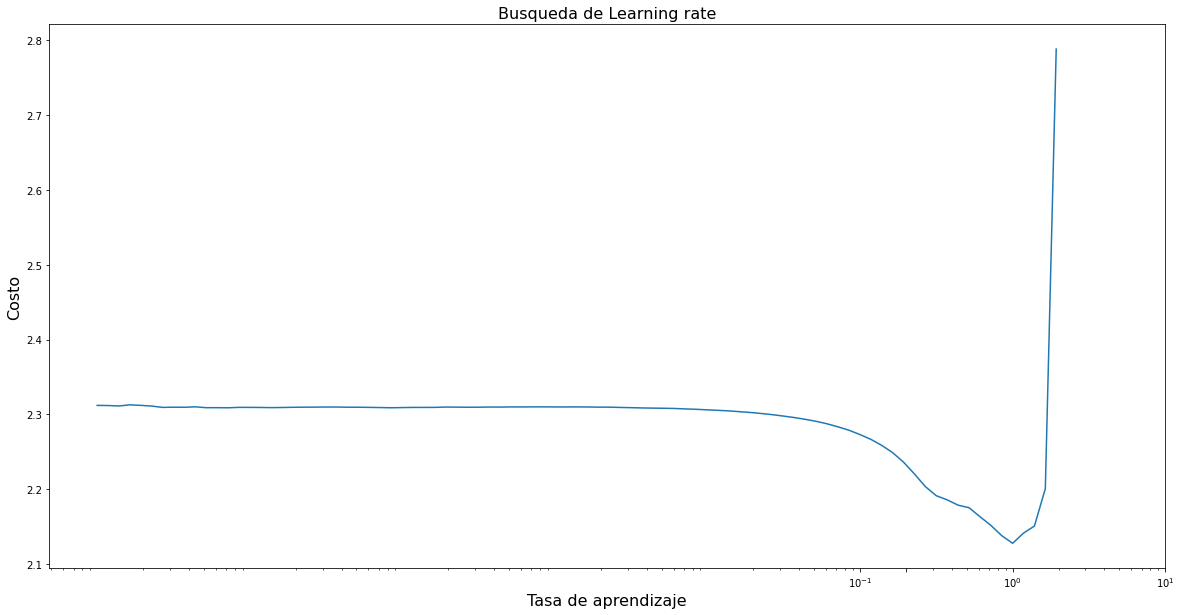

In [158]:
f1, ax1 = plt.subplots(figsize=(20,10))

fontDict = {'fontsize': 16}

ax1.plot(lg_lr[:-1], losses[:-1])
ax1.set_xscale('log')
ax1.set_xticks([1e-1,2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False

ax1.set_title("Busqueda de Learning rate", fontdict= fontDict)
ax1.set_xlabel("Tasa de aprendizaje", fontdict= fontDict)
ax1.set_ylabel("Costo", fontdict= fontDict)
plt.show()

# Uncomment this if you want to see accuracie too
# f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lg_lr[:-1], accuracies[:-1])
# # ax1.plot(lg_lr, accuracies)
# ax1.set_xscale('log')
# ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
# ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
# plt.show()

## Tasa de aprendizaje fija

Mantiene un $\alpha$ constante durante todo el entrenamiento

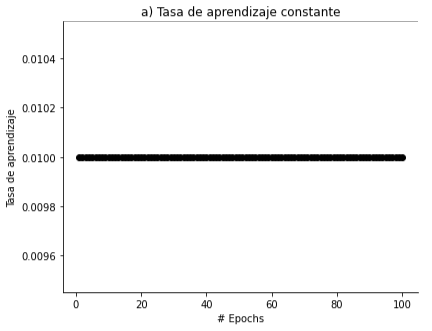

In [159]:
def Fixed():
    modelFixed = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelFixed.parameters(), lr=lr)


    start.record()
    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_epochs = train(modelFixed, optimizer,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    fixed_time = start.elapsed_time(end)

    fixed_acc = accuracy(modelFixed, x_test_tensor,  y_test_tensor, mb_size)

    return fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc, fixed_epochs


In [160]:

resultados['fixed'] = {}
resultados['fixed']['val_acc_list'] = [0] * epochs
resultados['fixed']['test_acc'] = 0
resultados['fixed']['cost'] = [0] * epochs
resultados['fixed']['time'] = 0
resultados['fixed']['epochs'] = 0


for _ in range(MAX_ITERATIONS):
    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc, fixed_epochs = Fixed()
    resultados['fixed']['val_acc_list'] = SumList(resultados['fixed']['val_acc_list'], fixed_acc_list)
    resultados['fixed']['test_acc'] += fixed_acc
    resultados['fixed']['cost'] = SumList(resultados['fixed']['cost'], fixed_cost_list)
    resultados['fixed']['time'] += fixed_time
    resultados['fixed']['epochs'] += fixed_epochs

#Saving results
resultados['fixed']['name'] = 'Fijo'
resultados['fixed']['lr'] = fixed_lr_list
resultados['fixed']['test_acc'] = resultados['fixed']['test_acc'] / MAX_ITERATIONS
resultados['fixed']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['fixed']['val_acc_list'], MAX_ITERATIONS))
resultados['fixed']['cost'] = DeleteZerosFromList(DivideList(resultados['fixed']['cost'], MAX_ITERATIONS))
resultados['fixed']['time'] = resultados['fixed']['time']/ MAX_ITERATIONS
resultados['fixed']['epochs'] = resultados['fixed']['epochs'] / MAX_ITERATIONS


Epoch: 1, learning_rate:0.01,costo: 2.25160813331604, accuracy: 0.3818359375
Epoch: 2, learning_rate:0.01,costo: 2.183955430984497, accuracy: 0.58203125
Epoch: 3, learning_rate:0.01,costo: 2.0966148376464844, accuracy: 0.656005859375
Epoch: 4, learning_rate:0.01,costo: 2.0145151615142822, accuracy: 0.700927734375
Epoch: 5, learning_rate:0.01,costo: 1.9311206340789795, accuracy: 0.73681640625
Epoch: 6, learning_rate:0.01,costo: 1.8034452199935913, accuracy: 0.755615234375
Epoch: 7, learning_rate:0.01,costo: 1.7056641578674316, accuracy: 0.76416015625
Epoch: 8, learning_rate:0.01,costo: 1.5849531888961792, accuracy: 0.767822265625
Epoch: 9, learning_rate:0.01,costo: 1.4661020040512085, accuracy: 0.79150390625
Epoch: 10, learning_rate:0.01,costo: 1.3345223665237427, accuracy: 0.788330078125
Epoch: 11, learning_rate:0.01,costo: 1.2247319221496582, accuracy: 0.802734375
Epoch: 12, learning_rate:0.01,costo: 1.1355869770050049, accuracy: 0.81884765625
Epoch: 13, learning_rate:0.01,costo: 1.02

## Tasa de aprendizaje decreciente (PyTorch)

Inicia con un $\alpha$ inicial y va decreciendo en por un factor $gamma$. El decrecimiento se da un numero $l$ de epochs definidos

$\alpha: 1x10^{-2}$

$gamma: 7x10^{-1}$

$l: 10$ epochs

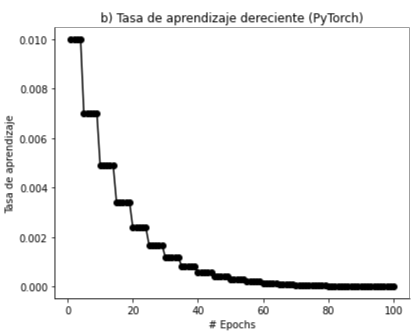

In [161]:
def Decay():
    modelDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelDecay.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7, last_epoch=-1, verbose=False)

    start.record()
    decay_acc_list, decay_cost_list, decay_lr_list, decay_epochs = train(modelDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    decay_time = start.elapsed_time(end)

    decay_acc = accuracy(modelDecay, x_test_tensor,  y_test_tensor, mb_size)
    
    return decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc, decay_epochs

In [162]:

resultados['decay'] = {}
resultados['decay']['val_acc_list'] = [0] * epochs
resultados['decay']['test_acc'] = 0
resultados['decay']['cost'] = [0] * epochs
resultados['decay']['time'] = 0
resultados['decay']['epochs'] = 0


for _ in range(MAX_ITERATIONS):
    decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc, decay_epochs = Decay()
    resultados['decay']['val_acc_list'] = SumList(resultados['decay']['val_acc_list'], decay_acc_list)
    resultados['decay']['test_acc'] += decay_acc
    resultados['decay']['cost'] = SumList(resultados['decay']['cost'], decay_cost_list)
    resultados['decay']['time'] += decay_time
    resultados['decay']['epochs'] += decay_epochs

#Saving results
resultados['decay']['name'] = 'Decreciente'
resultados['decay']['lr'] = decay_lr_list
resultados['decay']['test_acc'] = resultados['decay']['test_acc'] / MAX_ITERATIONS
resultados['decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['decay']['val_acc_list'], MAX_ITERATIONS))
resultados['decay']['cost'] = DeleteZerosFromList(DivideList(resultados['decay']['cost'], MAX_ITERATIONS))
resultados['decay']['time'] = resultados['decay']['time']/ MAX_ITERATIONS
resultados['decay']['epochs'] = resultados['decay']['epochs'] / MAX_ITERATIONS


Epoch: 1, learning_rate:[0.01],costo: 2.2422029972076416, accuracy: 0.410400390625
Epoch: 2, learning_rate:[0.01],costo: 2.163412570953369, accuracy: 0.60693359375
Epoch: 3, learning_rate:[0.01],costo: 2.0889432430267334, accuracy: 0.685546875
Epoch: 4, learning_rate:[0.01],costo: 2.0193989276885986, accuracy: 0.72607421875
Epoch: 5, learning_rate:[0.01],costo: 1.9002736806869507, accuracy: 0.7392578125
Epoch: 6, learning_rate:[0.01],costo: 1.7944772243499756, accuracy: 0.744384765625
Epoch: 7, learning_rate:[0.01],costo: 1.6775572299957275, accuracy: 0.772705078125
Epoch: 8, learning_rate:[0.01],costo: 1.565395712852478, accuracy: 0.778564453125
Epoch: 9, learning_rate:[0.01],costo: 1.4370768070220947, accuracy: 0.789306640625
Epoch: 10, learning_rate:[0.006999999999999999],costo: 1.2830824851989746, accuracy: 0.80322265625
Epoch: 11, learning_rate:[0.006999999999999999],costo: 1.2298848628997803, accuracy: 0.8076171875
Epoch: 12, learning_rate:[0.006999999999999999],costo: 1.15973711

In [163]:
print(fixed_epochs)

0


## Tasa de aprendizaje cíclica

Oscila entre una $base\_ta$ y un $max\_ta$ cada $n$ epochs en una proporción igual a 

$$
proporción\_de\_cambio = \frac{max\_ta - base\_ta}{n}
$$

Esta implementación facilitada por PyTorch, está basada en la publicación de Tasas de aprendizaje cíclico para la red neuronal de entrenamiento (*Cyclical Learning Rates for Training Neural Networks* o por sus siglas CLR) de Leslie Smith, 2017.

$\alpha: 1x10^{-2}$

$beta: 0.9$




 

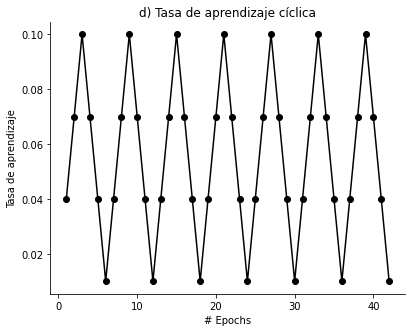

In [164]:
def Cyclic():
    modelCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelCyclic.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3,cycle_momentum=False )

    start.record()
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_epochs= train(modelCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    cyclic_time = start.elapsed_time(end)

    cyclic_acc = accuracy(modelCyclic, x_test_tensor,  y_test_tensor, mb_size)

    return cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc, cyclic_epochs

In [165]:
resultados['cyclic'] = {}
resultados['cyclic']['val_acc_list'] = [0]* epochs
resultados['cyclic']['test_acc'] = 0
resultados['cyclic']['cost'] = [0] * epochs
resultados['cyclic']['time'] = 0
resultados['cyclic']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc, cyclic_epochs = Cyclic()
    resultados['cyclic']['val_acc_list'] = SumList(resultados['cyclic']['val_acc_list'], cyclic_acc_list)
    resultados['cyclic']['test_acc'] += cyclic_acc
    resultados['cyclic']['cost'] = SumList(resultados['cyclic']['cost'], cyclic_cost_list)
    resultados['cyclic']['time'] += cyclic_time
    resultados['cyclic']['epochs'] += cyclic_epochs

#Saving results
resultados['cyclic']['name'] = 'Ciclico'
resultados['cyclic']['lr'] = cyclic_lr_list
resultados['cyclic']['test_acc'] = resultados['cyclic']['test_acc'] / MAX_ITERATIONS
resultados['cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['cyclic']['cost'], MAX_ITERATIONS))
resultados['cyclic']['time'] = resultados['cyclic']['time']/ MAX_ITERATIONS
resultados['cyclic']['epochs'] = resultados['cyclic']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:[0.040000000000000015],costo: 2.248638153076172, accuracy: 0.377685546875
Epoch: 2, learning_rate:[0.06999999999999999],costo: 1.9430902004241943, accuracy: 0.737060546875
Epoch: 3, learning_rate:[0.1],costo: 1.1555415391921997, accuracy: 0.8154296875
Epoch: 4, learning_rate:[0.07000000000000003],costo: 0.6506248116493225, accuracy: 0.79931640625
Epoch: 5, learning_rate:[0.03999999999999998],costo: 0.5760264992713928, accuracy: 0.875244140625
Epoch: 6, learning_rate:[0.01],costo: 0.5448167324066162, accuracy: 0.8896484375
Epoch: 7, learning_rate:[0.040000000000000056],costo: 0.5027066469192505, accuracy: 0.89599609375
Epoch: 8, learning_rate:[0.06999999999999995],costo: 0.4813258945941925, accuracy: 0.889404296875
Epoch: 9, learning_rate:[0.1],costo: 0.4476306140422821, accuracy: 0.89013671875
Epoch: 10, learning_rate:[0.06999999999999995],costo: 0.40396198630332947, accuracy: 0.90869140625
Epoch: 11, learning_rate:[0.040000000000000056],costo: 0.366977185010910

## Tasa de aprendizaje cíclica aleatoria (propuesta)

Oscila entre una $base\_ta$ y un $max\_ta$ cada $n$ epochs en una proporción aleatoria.

$base\_ta: 1x10^{-2}$

$max\_ta: 1x10^{-1}$

$n: 3$ epochs

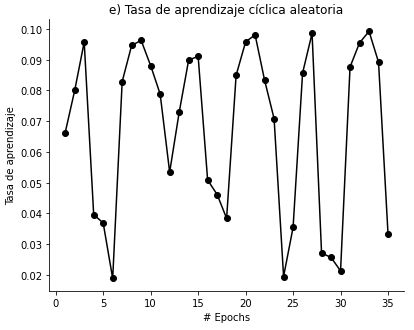

In [166]:
def CyclicGD():
    modelRandomCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic.parameters(), lr=lr)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_mode='chipichipi')

    start.record()
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_epochs= train(modelRandomCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize() 
    random_cyclic_time = start.elapsed_time(end)

    random_cyclic_acc = accuracy(modelRandomCyclic, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc, random_cyclic_epochs

In [167]:
resultados['random_cyclic'] = {}
resultados['random_cyclic']['val_acc_list'] = [0] * epochs
resultados['random_cyclic']['test_acc'] = 0
resultados['random_cyclic']['cost'] = [0] * epochs
resultados['random_cyclic']['time'] = 0
resultados['random_cyclic']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc, random_cyclic_epochs = CyclicGD()
    a = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['val_acc_list'] = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['test_acc'] += random_cyclic_acc
    resultados['random_cyclic']['cost'] = SumList(resultados['random_cyclic']['cost'], random_cyclic_cost_list)
    resultados['random_cyclic']['time'] += random_cyclic_time
    resultados['random_cyclic']['epochs'] += random_cyclic_epochs

#Saving results
resultados['random_cyclic']['name'] = 'Random Ciclico'
resultados['random_cyclic']['lr'] = random_cyclic_lr_list
resultados['random_cyclic']['test_acc'] = resultados['random_cyclic']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['cost'], MAX_ITERATIONS))
resultados['random_cyclic']['time'] = resultados['random_cyclic']['time']/ MAX_ITERATIONS
resultados['random_cyclic']['epochs'] = resultados['random_cyclic']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:[0.044303917137064094],costo: 2.216787338256836, accuracy: 0.463134765625
Epoch: 2, learning_rate:[0.0917003792014144],costo: 1.8769702911376953, accuracy: 0.763916015625
Epoch: 3, learning_rate:[0.09751816498385103],costo: 0.9487673044204712, accuracy: 0.831298828125
Epoch: 4, learning_rate:[0.01823552869923942],costo: 0.6388390064239502, accuracy: 0.846435546875
Epoch: 5, learning_rate:[0.013902870317307988],costo: 0.5670807361602783, accuracy: 0.88232421875
Epoch: 6, learning_rate:[0.010211373301078488],costo: 0.5409384965896606, accuracy: 0.885986328125
Epoch: 7, learning_rate:[0.020037181914111295],costo: 0.5243009328842163, accuracy: 0.886962890625
Epoch: 8, learning_rate:[0.03684175184507353],costo: 0.594070315361023, accuracy: 0.88818359375
Epoch: 9, learning_rate:[0.07800851662950317],costo: 0.45743390917778015, accuracy: 0.887451171875
Epoch: 10, learning_rate:[0.039373520665634786],costo: 0.43954998254776, accuracy: 0.90234375
Epoch: 11, learning_rate

### Pruebas politicas de eleccion de LR aleatorio

In [168]:
def CyclicGDDecrement():
    modelRandomCyclic_Decrement = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic_Decrement.parameters(), lr=lr)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_mode='decrementar_maximo')

    start.record()
    random_cyclic_decrement_acc_list, random_cyclic_decrement_cost_list, random_cyclic_decrement_lr_list, random_cyclic_decrement_epochs= train(modelRandomCyclic_Decrement, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize() 
    random_cyclic_decrement_time = start.elapsed_time(end)

    random_cyclic_decrement_acc = accuracy(modelRandomCyclic_Decrement, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_decrement_acc_list, random_cyclic_decrement_cost_list, random_cyclic_decrement_lr_list, random_cyclic_decrement_time, random_cyclic_decrement_acc, random_cyclic_decrement_epochs

In [169]:
resultados['random_cyclic_decrement'] = {}
resultados['random_cyclic_decrement']['val_acc_list'] = [0] * epochs
resultados['random_cyclic_decrement']['test_acc'] = 0
resultados['random_cyclic_decrement']['cost'] = [0] * epochs
resultados['random_cyclic_decrement']['time'] = 0
resultados['random_cyclic_decrement']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    random_cyclic_decrement_acc_list, random_cyclic_decrement_cost_list, random_cyclic_decrement_lr_list, random_cyclic_decrement_time, random_cyclic_decrement_acc, random_cyclic_decrement_epochs = CyclicGDDecrement()
    a = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_decrement_acc_list)
    resultados['random_cyclic_decrement']['val_acc_list'] = SumList(resultados['random_cyclic_decrement']['val_acc_list'], random_cyclic_decrement_acc_list)
    resultados['random_cyclic_decrement']['test_acc'] += random_cyclic_decrement_acc
    resultados['random_cyclic_decrement']['cost'] = SumList(resultados['random_cyclic_decrement']['cost'], random_cyclic_decrement_cost_list)
    resultados['random_cyclic_decrement']['time'] += random_cyclic_decrement_time
    resultados['random_cyclic_decrement']['epochs'] += random_cyclic_decrement_epochs

#Saving results
resultados['random_cyclic_decrement']['name'] = 'Random Ciclico Decreciente'
resultados['random_cyclic_decrement']['lr'] = random_cyclic_decrement_lr_list
resultados['random_cyclic_decrement']['test_acc'] = resultados['random_cyclic_decrement']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic_decrement']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_decrement']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic_decrement']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_decrement']['cost'], MAX_ITERATIONS))
resultados['random_cyclic_decrement']['time'] = resultados['random_cyclic_decrement']['time']/ MAX_ITERATIONS
resultados['random_cyclic_decrement']['epochs'] = resultados['random_cyclic_decrement']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:[0.058110619283941956],costo: 2.2464373111724854, accuracy: 0.366943359375
Epoch: 2, learning_rate:[0.09432613209106391],costo: 1.7821718454360962, accuracy: 0.760009765625
Proximo maxLR 0.1
Epoch: 3, learning_rate:[0.09609028161304523],costo: 0.8868409395217896, accuracy: 0.81591796875
Epoch: 4, learning_rate:[0.04589818252504168],costo: 0.7340680956840515, accuracy: 0.810302734375
Epoch: 5, learning_rate:[0.010048930887876777],costo: 0.5219454765319824, accuracy: 0.885498046875
Epoch: 6, learning_rate:[0.010039311387850263],costo: 0.47814011573791504, accuracy: 0.886962890625
Epoch: 7, learning_rate:[0.05438666906172778],costo: 0.5060631632804871, accuracy: 0.888427734375
Epoch: 8, learning_rate:[0.05981879805496268],costo: 0.48653167486190796, accuracy: 0.895263671875
Proximo maxLR 0.1
Epoch: 9, learning_rate:[0.08232591724941954],costo: 0.4693700075149536, accuracy: 0.900390625
Epoch: 10, learning_rate:[0.06030957239613227],costo: 0.39742815494537354, accura

In [170]:
def CyclicGDExtended():
    modelRandomCyclic_Extended = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic_Extended.parameters(), lr=lr)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_mode='extendido')

    start.record()
    random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_epochs= train(modelRandomCyclic_Extended, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize() 
    random_cyclic_extended_time = start.elapsed_time(end)

    random_cyclic_extended_acc = accuracy(modelRandomCyclic_Extended, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_time, random_cyclic_extended_acc, random_cyclic_extended_epochs

In [171]:
resultados['random_cyclic_extended'] = {}
resultados['random_cyclic_extended']['val_acc_list'] = [0] * epochs
resultados['random_cyclic_extended']['test_acc'] = 0
resultados['random_cyclic_extended']['cost'] = [0] * epochs
resultados['random_cyclic_extended']['time'] = 0
resultados['random_cyclic_extended']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    random_cyclic_extended_acc_list, random_cyclic_extended_cost_list, random_cyclic_extended_lr_list, random_cyclic_extended_time, random_cyclic_extended_acc, random_cyclic_extended_epochs = CyclicGDExtended()
    a = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_extended_acc_list)
    resultados['random_cyclic_extended']['val_acc_list'] = SumList(resultados['random_cyclic_extended']['val_acc_list'], random_cyclic_extended_acc_list)
    resultados['random_cyclic_extended']['test_acc'] += random_cyclic_extended_acc
    resultados['random_cyclic_extended']['cost'] = SumList(resultados['random_cyclic_extended']['cost'], random_cyclic_extended_cost_list)
    resultados['random_cyclic_extended']['time'] += random_cyclic_extended_time
    resultados['random_cyclic_extended']['epochs'] += random_cyclic_extended_epochs

#Saving results
resultados['random_cyclic_extended']['name'] = 'Random Ciclico Extended'
resultados['random_cyclic_extended']['lr'] = random_cyclic_extended_lr_list
resultados['random_cyclic_extended']['test_acc'] = resultados['random_cyclic_extended']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic_extended']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_extended']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic_extended']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic_extended']['cost'], MAX_ITERATIONS))
resultados['random_cyclic_extended']['time'] = resultados['random_cyclic_extended']['time']/ MAX_ITERATIONS
resultados['random_cyclic_extended']['epochs'] = resultados['random_cyclic_extended']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:[0.07598997491250065],costo: 1.8642619848251343, accuracy: 0.714111328125
Epoch: 2, learning_rate:[0.08593341721289263],costo: 1.048657774925232, accuracy: 0.808349609375
Epoch: 3, learning_rate:[0.09981786051598979],costo: 0.688590943813324, accuracy: 0.85546875
Epoch: 4, learning_rate:[0.09982066054905785],costo: 0.596625804901123, accuracy: 0.869140625
Epoch: 5, learning_rate:[0.04179110492251436],costo: 0.46497276425361633, accuracy: 0.896484375
Epoch: 6, learning_rate:[0.034633836827354846],costo: 0.40228500962257385, accuracy: 0.8935546875
Epoch: 7, learning_rate:[0.034358954143673216],costo: 0.4175891876220703, accuracy: 0.905517578125
Epoch: 8, learning_rate:[0.013265449439844446],costo: 0.407337486743927, accuracy: 0.906982421875
Epoch: 9, learning_rate:[0.03477564748633187],costo: 0.43534672260284424, accuracy: 0.912109375
Epoch: 10, learning_rate:[0.03712840604944348],costo: 0.41113582253456116, accuracy: 0.90478515625
Epoch: 11, learning_rate:[0.0660

## Tasa de aprendizaje decreciente (Propuesta)

Inicia con una tasa de aprendizaje $\alpha$ inicial y posee una disminución de 0.001 cada $p$ epochs.

$\alpha: 1x10^{-2}$

$p: 1$ epochs

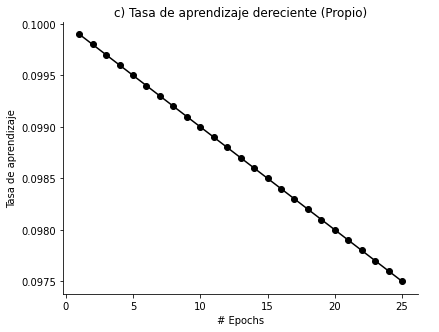

In [172]:
def Our_Decay():
    modelOurDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelOurDecay.parameters(), lr=lr)


    clr_fn = lambda x, y: random.uniform(x, y)
    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.0001, max_lr=0.1, step_size_up=1,scale_mode='decrecimiento')

    start.record()
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_epochs = train(modelOurDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    our_decay_time = start.elapsed_time(end)

    our_decay_acc = accuracy(modelOurDecay, x_test_tensor,  y_test_tensor, mb_size)

    return our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs

In [173]:
resultados['our_decay'] = {}
resultados['our_decay']['val_acc_list'] = [0] * epochs
resultados['our_decay']['test_acc'] = 0
resultados['our_decay']['cost'] = [0] * epochs
resultados['our_decay']['time'] = 0
resultados['our_decay']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs = Our_Decay()
    resultados['our_decay']['val_acc_list'] = SumList(resultados['our_decay']['val_acc_list'], our_decay_acc_list)
    resultados['our_decay']['test_acc'] += our_decay_acc
    resultados['our_decay']['cost'] = SumList(resultados['our_decay']['cost'], our_decay_cost_list)
    resultados['our_decay']['time'] += our_decay_time
    resultados['our_decay']['epochs'] += our_decay_epochs

#Saving results
resultados['our_decay']['name'] = 'Our Decay'
resultados['our_decay']['lr'] = our_decay_lr_list
resultados['our_decay']['test_acc'] = resultados['our_decay']['test_acc'] / MAX_ITERATIONS
resultados['our_decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['our_decay']['val_acc_list'], MAX_ITERATIONS))
resultados['our_decay']['cost'] = DeleteZerosFromList(DivideList(resultados['our_decay']['cost'], MAX_ITERATIONS))
resultados['our_decay']['time'] = resultados['our_decay']['time'] / MAX_ITERATIONS
resultados['our_decay']['epochs'] = resultados['our_decay']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:[0.0999],costo: 1.47914719581604, accuracy: 0.7900390625
Epoch: 2, learning_rate:[0.0998],costo: 0.7486567497253418, accuracy: 0.830078125
Epoch: 3, learning_rate:[0.0997],costo: 0.6173260807991028, accuracy: 0.867919921875
Epoch: 4, learning_rate:[0.0996],costo: 0.46374785900115967, accuracy: 0.890869140625
Epoch: 5, learning_rate:[0.09949999999999999],costo: 0.3825925290584564, accuracy: 0.903564453125
Epoch: 6, learning_rate:[0.09939999999999999],costo: 0.3642328381538391, accuracy: 0.90625
Epoch: 7, learning_rate:[0.09929999999999999],costo: 0.39242270588874817, accuracy: 0.9140625
Epoch: 8, learning_rate:[0.09919999999999998],costo: 0.34845733642578125, accuracy: 0.910400390625
Epoch: 9, learning_rate:[0.09909999999999998],costo: 0.3073211908340454, accuracy: 0.921142578125
Epoch: 10, learning_rate:[0.09899999999999998],costo: 0.3327028155326843, accuracy: 0.920654296875
Epoch: 11, learning_rate:[0.09889999999999997],costo: 0.3112030625343323, accuracy: 0.9

## L-BFGS

Derivado del método BFGS pero con memoria limitada. Considera información de las $h$ iteraciones previas

$\alpha: 1$

$h: 10$ iteraciones

In [174]:
def LBFGS():
    modelLBFGS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                max_iter=1, #maximal number of iterations per optimization step
                                )

    lbfgs_cost_list = [0.0]
    lbfgs_acc_list = [0.0]
    modelLBFGS = modelLBFGS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0
    unregistered = True
    iter_found = 0
    iteraciones_lbfgs = 0
    start.record()
    #training
    while (i < 100):
        if(lbfgs_acc_list[-1] >= 0.95 and unregistered):
          iter_found = i
          unregistered = False
        #print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            print(f'costo: {cost.item()}')
            return cost
        iteraciones_lbfgs += 1
        cost = optimizer.step(closure)
        lbfgs_cost_list.append(cost.item())
        lbfgs_acc_list.append(accuracy(modelLBFGS, x_val_tensor, y_val_tensor, mb_size))
        #print(f'accuracy: {lbfgs_acc_list[-1]}')
        i+=1
    end.record()

    torch.cuda.synchronize()
    lbfgs_time = start.elapsed_time(end)

    lbfgs_acc = accuracy(modelLBFGS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_acc_list, lbfgs_cost_list, [0] ,lbfgs_time, lbfgs_acc, iter_found, iteraciones_lbfgs

In [175]:
resultados['lbfgs'] = {}
resultados['lbfgs']['val_acc_list'] = [0] * epochs
resultados['lbfgs']['test_acc'] = 0
resultados['lbfgs']['cost'] = [0] * epochs
resultados['lbfgs']['time'] = 0
resultados['lbfgs']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    lbfgs_acc_list, lbfgs_cost_list, lbfgs_lr_list, lbfgs_time, lbfgs_acc, lbfgs_epochs, iteraciones_lbfgs = LBFGS()
    resultados['lbfgs']['val_acc_list'] = SumList(resultados['lbfgs']['val_acc_list'], lbfgs_acc_list)
    resultados['lbfgs']['test_acc'] += lbfgs_acc
    resultados['lbfgs']['cost'] = SumList(resultados['lbfgs']['cost'], lbfgs_cost_list)
    resultados['lbfgs']['time'] += lbfgs_time
    resultados['lbfgs']['epochs'] += lbfgs_epochs

#Saving results
resultados['lbfgs']['name'] = 'LBFGS'
resultados['lbfgs']['lr'] = lbfgs_lr_list
resultados['lbfgs']['test_acc'] = resultados['lbfgs']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['cost'], MAX_ITERATIONS))
resultados['lbfgs']['time'] = resultados['lbfgs']['time'] / MAX_ITERATIONS
resultados['lbfgs']['epochs'] = resultados['lbfgs']['epochs'] / MAX_ITERATIONS



costo: 2.3184101581573486
costo: 2.3147385120391846
costo: 1.8390119075775146
costo: 0.9171377420425415
costo: 2.562251567840576
costo: 0.7213003635406494
costo: 0.6412680149078369
costo: 0.5916130542755127
costo: 0.5610097050666809
costo: 0.5435361266136169
costo: 0.5183135867118835
costo: 0.4723323583602905
costo: 0.44637253880500793
costo: 0.41344308853149414
costo: 0.39087823033332825
costo: 0.3717464804649353
costo: 0.35340219736099243
costo: 0.332141637802124
costo: 0.32245197892189026
costo: 0.3138311803340912
costo: 0.3010069727897644
costo: 0.2870526611804962
costo: 0.2727387547492981
costo: 0.2658909261226654
costo: 0.2550671398639679
costo: 0.24557709693908691
costo: 0.2357853502035141
costo: 0.22733403742313385
costo: 0.21915261447429657
costo: 0.21260416507720947
costo: 0.2053450644016266
costo: 0.19754251837730408
costo: 0.19136455655097961
costo: 0.18684908747673035
costo: 0.18054214119911194
costo: 0.17414771020412445
costo: 0.16577953100204468
costo: 0.1568031311035156

## L-BFGS con búsqueda lineal

Posee la misma implementación del método L-BFGS con la diferencia de que se agregan *las condiciones fuertes de Wolfe*

In [176]:
def LBFGS_LS():
    modelLBFGS_LS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS_LS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
                                #max_iter=1,
                                line_search_fn="strong_wolfe"
                                )

    lbfgs_ls_cost_list = [0.0]
    lbfgs_ls_acc_list = [0.0]
    modelLBFGS_LS = modelLBFGS_LS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0
    iter_found = 0
    unregistered = True
    iteraciones_lbfgs_ls = []
    start.record()
    #training
    while (i < 100):
        if(lbfgs_ls_acc_list[-1] >= 0.95 and unregistered):
            iter_found = i
            unregistered = False
        print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS_LS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            print(f'costo: {cost.item()}')  
            iteraciones_lbfgs_ls.append('0')
            return cost
        lbfgs_ls_cost_list.append(optimizer.step(closure).item())
        lbfgs_ls_acc_list.append(accuracy(modelLBFGS_LS, x_val_tensor, y_val_tensor, mb_size))
        i+=1
            
    #print(f'accuracy: {lbfgs_ls_acc_list[-1]}')
    end.record()

    torch.cuda.synchronize()
    lbfgs_ls_time = start.elapsed_time(end)

    lbfgs_ls_acc = accuracy(modelLBFGS_LS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_ls_acc_list, lbfgs_ls_cost_list, [0] ,lbfgs_ls_time, lbfgs_ls_acc, iter_found, iteraciones_lbfgs_ls

In [177]:
resultados['lbfgs_ls'] = {}
resultados['lbfgs_ls']['val_acc_list'] = [0] * epochs
resultados['lbfgs_ls']['test_acc'] = 0
resultados['lbfgs_ls']['cost'] = [0] * epochs
resultados['lbfgs_ls']['time'] = 0
resultados['lbfgs_ls']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    lbfgs_ls_acc_list, lbfgs_ls_cost_list, lbfgs_ls_lr_list ,lbfgs_ls_time, lbfgs_ls_acc, lbfgs_ls_epochs, iteraciones_lbfgs_ls = LBFGS_LS()
    resultados['lbfgs_ls']['val_acc_list'] = SumList(resultados['lbfgs_ls']['val_acc_list'], lbfgs_ls_acc_list)
    resultados['lbfgs_ls']['test_acc'] += lbfgs_ls_acc
    resultados['lbfgs_ls']['cost'] = SumList(resultados['lbfgs_ls']['cost'], lbfgs_ls_cost_list)
    resultados['lbfgs_ls']['time'] += lbfgs_ls_time
    resultados['lbfgs_ls']['epochs'] += lbfgs_ls_epochs

#Saving results
resultados['lbfgs_ls']['name'] = 'LBFGS With LS'
resultados['lbfgs_ls']['lr'] = lbfgs_ls_lr_list
resultados['lbfgs_ls']['test_acc'] = resultados['lbfgs_ls']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs_ls']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs_ls']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['cost'], MAX_ITERATIONS))
resultados['lbfgs_ls']['time'] = resultados['lbfgs_ls']['time'] / MAX_ITERATIONS
resultados['lbfgs_ls']['epochs'] = resultados['lbfgs_ls']['epochs'] / MAX_ITERATIONS

Iteracion: 0
costo: 2.313084602355957
costo: 2.3124091625213623
costo: 2.3076837062835693
costo: 2.2977144718170166
costo: 2.2772324085235596
costo: 2.124504327774048
costo: 1.491049885749817
costo: 1.0701357126235962
costo: 0.7966882586479187
costo: 0.7153726816177368
costo: 0.6694265604019165
costo: 0.6209958791732788
costo: 0.6236339807510376
costo: 0.602003812789917
costo: 0.5722835063934326
costo: 0.506614625453949
costo: 0.4806576669216156
costo: 0.4302619397640228
costo: 0.4099113941192627
costo: 0.39064037799835205
costo: 0.3752562403678894
costo: 0.34954050183296204
costo: 0.3257196247577667
costo: 0.3061652183532715
costo: 0.2925805151462555
Iteracion: 1
costo: 0.26596882939338684
costo: 0.2474745661020279
costo: 0.2313930243253708
costo: 0.22081902623176575
costo: 0.20874470472335815
costo: 0.1930442452430725
costo: 0.18082749843597412
costo: 0.17385277152061462
costo: 0.16397343575954437
costo: 0.15346527099609375
costo: 0.142857164144516
costo: 0.13587307929992676
costo: 0

## Adam

$\alpha: 1x10^{-2}$ 

$beta1: 0.9$

$beta2: 0.999$

In [178]:
def Adam():
    modelAdam = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
    start.record()
    adam_acc_list, adam_cost_list,adam_lr_list, adam_epochs = train(modelAdam,optimiserAdam,None, mb_size)
    end.record()


    torch.cuda.synchronize()
    adam_time = start.elapsed_time(end)

    adam_acc = accuracy(modelAdam, x_test_tensor,  y_test_tensor, mb_size)

    return adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs

In [179]:

resultados['adam'] = {}
resultados['adam']['val_acc_list'] = [0] * epochs
resultados['adam']['test_acc'] = 0
resultados['adam']['cost'] = [0] * epochs
resultados['adam']['time'] = 0
resultados['adam']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs = Adam()
    resultados['adam']['val_acc_list'] = SumList(resultados['adam']['val_acc_list'], adam_acc_list)
    resultados['adam']['test_acc'] += adam_acc
    resultados['adam']['cost'] = SumList(resultados['adam']['cost'], adam_cost_list)
    resultados['adam']['time'] += adam_time
    resultados['adam']['epochs'] += adam_epochs

#Saving results
resultados['adam']['name'] = 'Adam'
resultados['adam']['lr'] = adam_lr_list
resultados['adam']['test_acc'] = resultados['adam']['test_acc'] / MAX_ITERATIONS
resultados['adam']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['adam']['val_acc_list'], MAX_ITERATIONS))
resultados['adam']['cost'] = DeleteZerosFromList(DivideList(resultados['adam']['cost'], MAX_ITERATIONS))
resultados['adam']['time'] = resultados['adam']['time'] / MAX_ITERATIONS
resultados['adam']['epochs'] = resultados['adam']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:0.01,costo: 0.7938874363899231, accuracy: 0.81298828125
Epoch: 2, learning_rate:0.01,costo: 0.4196564257144928, accuracy: 0.917724609375
Epoch: 3, learning_rate:0.01,costo: 0.2924187183380127, accuracy: 0.947998046875
Epoch: 4, learning_rate:0.01,costo: 0.24931350350379944, accuracy: 0.953857421875
Epoch: 5, learning_rate:0.01,costo: 0.18388192355632782, accuracy: 0.965087890625
Epoch: 6, learning_rate:0.01,costo: 0.16594216227531433, accuracy: 0.963623046875
Epoch: 7, learning_rate:0.01,costo: 0.2070113867521286, accuracy: 0.9677734375
Epoch: 8, learning_rate:0.01,costo: 0.11411704868078232, accuracy: 0.9658203125
Epoch: 9, learning_rate:0.01,costo: 0.12251268327236176, accuracy: 0.9716796875
Epoch: 10, learning_rate:0.01,costo: 0.15390004217624664, accuracy: 0.968994140625
Epoch: 11, learning_rate:0.01,costo: 0.13601817190647125, accuracy: 0.97509765625
Epoch: 12, learning_rate:0.01,costo: 0.14013993740081787, accuracy: 0.975341796875
Epoch: 13, learning_rate:

## Momentum

Se utiliza una optimización por el descenso del gradiente estocástico empleando Momentum.

$beta: 0.9$

In [180]:
def SGDM():
    modelSGDM = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserSGDM = torch.optim.SGD(modelSGDM.parameters(), lr=lr, momentum=0.9)
    start.record()
    SGDM_acc_list, SGDM_cost_list,SGDM_lr_list, SGDM_epochs = train(modelSGDM, optimiserSGDM,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    SGDM_time = start.elapsed_time(end)

    SGDM_acc = accuracy(modelSGDM, x_test_tensor,  y_test_tensor, mb_size)

    return SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc, SGDM_epochs

In [181]:
resultados['SGDM'] = {}
resultados['SGDM']['val_acc_list'] = [0] * epochs
resultados['SGDM']['test_acc'] = 0
resultados['SGDM']['cost'] = [0] * epochs
resultados['SGDM']['time'] = 0
resultados['SGDM']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc, SGDM_epochs = SGDM()
    resultados['SGDM']['val_acc_list'] = SumList(resultados['SGDM']['val_acc_list'], SGDM_acc_list)
    resultados['SGDM']['test_acc'] += SGDM_acc
    resultados['SGDM']['cost'] = SumList(resultados['SGDM']['cost'], SGDM_cost_list)
    resultados['SGDM']['time'] += SGDM_time
    resultados['SGDM']['epochs'] += SGDM_epochs

#Saving results
resultados['SGDM']['name'] = 'SGDM'
resultados['SGDM']['lr'] = SGDM_lr_list
resultados['SGDM']['test_acc'] = resultados['SGDM']['test_acc'] / MAX_ITERATIONS
resultados['SGDM']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['SGDM']['val_acc_list'], MAX_ITERATIONS))
resultados['SGDM']['cost'] = DeleteZerosFromList(DivideList(resultados['SGDM']['cost'], MAX_ITERATIONS))
resultados['SGDM']['time'] = resultados['SGDM']['time'] / MAX_ITERATIONS
resultados['SGDM']['epochs'] = resultados['SGDM']['epochs'] / MAX_ITERATIONS


Epoch: 1, learning_rate:0.01,costo: 1.9885278940200806, accuracy: 0.707275390625
Epoch: 2, learning_rate:0.01,costo: 1.2743209600448608, accuracy: 0.77392578125
Epoch: 3, learning_rate:0.01,costo: 0.6708737015724182, accuracy: 0.8515625
Epoch: 4, learning_rate:0.01,costo: 0.5112115144729614, accuracy: 0.8740234375
Epoch: 5, learning_rate:0.01,costo: 0.4348404109477997, accuracy: 0.8974609375
Epoch: 6, learning_rate:0.01,costo: 0.45350193977355957, accuracy: 0.89404296875
Epoch: 7, learning_rate:0.01,costo: 0.43678852915763855, accuracy: 0.9169921875
Epoch: 8, learning_rate:0.01,costo: 0.37155860662460327, accuracy: 0.907958984375
Epoch: 9, learning_rate:0.01,costo: 0.3603440523147583, accuracy: 0.916259765625
Epoch: 10, learning_rate:0.01,costo: 0.3344480097293854, accuracy: 0.91943359375
Epoch: 11, learning_rate:0.01,costo: 0.3390534818172455, accuracy: 0.92724609375
Epoch: 12, learning_rate:0.01,costo: 0.3168463110923767, accuracy: 0.9228515625
Epoch: 13, learning_rate:0.01,costo: 0.

## RMSProp

$\alpha: 1x10^{-2}$ 

$beta: 0.9$


In [182]:
def RMSP():
    modelRMSP = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserRMSP = torch.optim.RMSprop(modelRMSP.parameters(), lr=lr, alpha=0.9)
    start.record()
    RMSP_acc_list, RMSP_cost_list,RMSP_lr_list, RMSP_epochs = train(modelRMSP, optimiserRMSP,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    RMSP_time = start.elapsed_time(end)

    RMSP_acc = accuracy(modelRMSP, x_test_tensor,  y_test_tensor, mb_size)

    return RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc, RMSP_epochs

In [183]:
resultados['RMSP'] = {}
resultados['RMSP']['val_acc_list'] = [0] * epochs
resultados['RMSP']['test_acc'] = 0
resultados['RMSP']['cost'] = [0] * epochs
resultados['RMSP']['time'] = 0
resultados['RMSP']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc, RMSP_epochs = SGDM()
    resultados['RMSP']['val_acc_list'] = SumList(resultados['RMSP']['val_acc_list'], RMSP_acc_list)
    resultados['RMSP']['test_acc'] += RMSP_acc
    resultados['RMSP']['cost'] = SumList(resultados['RMSP']['cost'], RMSP_cost_list)
    resultados['RMSP']['time'] += RMSP_time
    resultados['RMSP']['epochs'] += RMSP_epochs

#Saving results
resultados['RMSP']['name'] = 'RMSP'
resultados['RMSP']['lr'] = RMSP_lr_list
resultados['RMSP']['test_acc'] = resultados['RMSP']['test_acc'] / MAX_ITERATIONS
resultados['RMSP']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['RMSP']['val_acc_list'], MAX_ITERATIONS))
resultados['RMSP']['cost'] = DeleteZerosFromList(DivideList(resultados['RMSP']['cost'], MAX_ITERATIONS))
resultados['RMSP']['time'] = resultados['RMSP']['time'] / MAX_ITERATIONS
resultados['RMSP']['epochs'] = resultados['RMSP']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:0.01,costo: 2.010974884033203, accuracy: 0.72216796875
Epoch: 2, learning_rate:0.01,costo: 1.2577069997787476, accuracy: 0.801513671875
Epoch: 3, learning_rate:0.01,costo: 0.7121779322624207, accuracy: 0.856201171875
Epoch: 4, learning_rate:0.01,costo: 0.5180617570877075, accuracy: 0.87646484375
Epoch: 5, learning_rate:0.01,costo: 0.4472227394580841, accuracy: 0.895263671875
Epoch: 6, learning_rate:0.01,costo: 0.4783427119255066, accuracy: 0.905517578125
Epoch: 7, learning_rate:0.01,costo: 0.43627381324768066, accuracy: 0.9169921875
Epoch: 8, learning_rate:0.01,costo: 0.374330997467041, accuracy: 0.915283203125
Epoch: 9, learning_rate:0.01,costo: 0.3511880338191986, accuracy: 0.913818359375
Epoch: 10, learning_rate:0.01,costo: 0.28147590160369873, accuracy: 0.921142578125
Epoch: 11, learning_rate:0.01,costo: 0.3295840620994568, accuracy: 0.923828125
Epoch: 12, learning_rate:0.01,costo: 0.33622753620147705, accuracy: 0.923828125
Epoch: 13, learning_rate:0.01,cost

# Resultados

Al guardar todos los resultados de cada método en sus respectivos diccionarios, se procede a crear un dataframe con estos resultados. Adicionalmente, se generan nuevas columnas derivadas de datos que ya disponemos y se hacen tratamiento de formato para su análisis.

In [184]:
for key, _ in resultados.items():
    if( resultados[key]['val_acc_list'][0] == 0 ):
        continue
    resultados[key]['val_acc_list'].insert(0,0)

In [185]:
import pandas as pd
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
# resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
# resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(100000),2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

### L-BFGS vs L-BFGS con búsqueda lineal

Comparación de número de veces que se procesa el conjunto de datos de pruebas completo

In [186]:
print(f'L-BFGS: {iteraciones_lbfgs}, L-BFGS con búsqueda:{len(iteraciones_lbfgs_ls)}')

L-BFGS: 100, L-BFGS con búsqueda:209


### Comportamiento de las trazas de aprendizaje no adaptativas

C:\Users\denis\AppData\Local\Temp\ipykernel_15120\1275811650.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


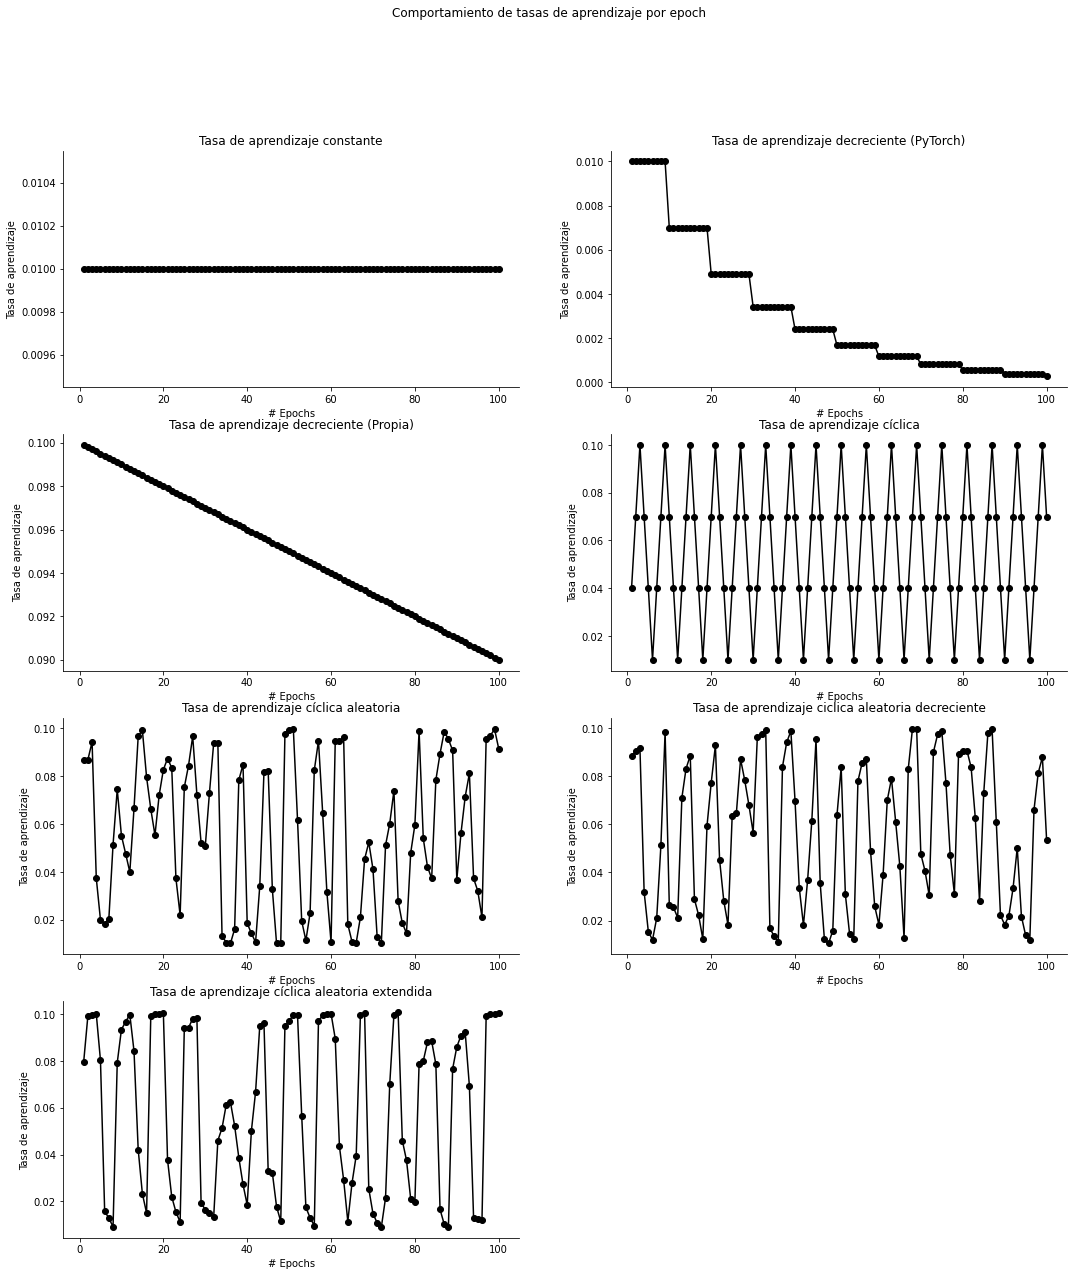

In [187]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(4,2,figsize=(18, 20))
# method = [fixed_lr_list, decay_lr_list, our_decay_lr_list,cyclic_lr_list, random_cyclic_lr_list]

method = [fixed_lr_list, 
          decay_lr_list, 
          our_decay_lr_list,  
          cyclic_lr_list, 
          random_cyclic_lr_list, 
          random_cyclic_decrement_lr_list, 
          random_cyclic_extended_lr_list]

names = ['Tasa de aprendizaje constante', 
         'Tasa de aprendizaje decreciente (PyTorch)',
         'Tasa de aprendizaje decreciente (Propia)',
         'Tasa de aprendizaje cíclica',
         'Tasa de aprendizaje cíclica aleatoria',
         'Tasa de aprendizaje ciclica aleatoria decreciente', 
         'Tasa de aprendizaje cíclica aleatoria extendida']
i = 0
for a in range(4):
  for b in range(2):
    if(a==3 and b==1):
      ax[a,b].spines['top'].set_visible(False)
      ax[a,b].spines['right'].set_visible(False)
      ax[a,b].spines['bottom'].set_visible(False)
      ax[a,b].spines['left'].set_visible(False)
      plt.axis('off')
      break
    ax[a,b].plot(range(len(method[i]))[1:], 
            method[i][1:], 
            'black',
            marker = 'o')
    #ax[a,b].set_xlim([1, len(method[i])])
    #ax[a,b].set_ylim([0, max(method[i]) + 0.01])
    ax[a,b].set_xlabel('# Epochs') #, fontsize = 18)
    ax[a,b].set_ylabel('Tasa de aprendizaje') #, fontsize = 18)
    ax[a,b].spines['top'].set_visible(False)
    ax[a,b].spines['right'].set_visible(False)
    #ax[a,b].xaxis.set_major_locator(MultipleLocator(len(method[i])//4))
    #ax[a,b].xaxis.set_minor_locator(MultipleLocator(len(method[i])//4))
    ax[a,b].set_title(names[i])
    i+=1


fig.suptitle('Comportamiento de tasas de aprendizaje por epoch')
fig.show()

### Velocidad de convergencia basado en epochs

In [188]:
resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

In [189]:
resultados_df[['name','epochs','time']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_15120\1767391596.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','epochs','time']].style.hide_index()


name,epochs,time
Fijo,0.000000,17134.461523
Decreciente,0.000000,19940.798307
LBFGS With LS,2.000000,25061.758333
Adam,3.666667,18745.655990
Our Decay,24.400000,20052.072526
SGDM,25.133333,18149.615755
RMSP,25.200000,18447.274089
LBFGS,34.000000,13990.242708
Random Ciclico,41.133333,19829.836198
Random Ciclico Extended,41.133333,20331.548177


### Curvas de aprendizaje: precisión


In [190]:
resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)
resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()

C:\Users\denis\AppData\Local\Temp\ipykernel_15120\4194298493.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','val_acc','time','test_acc', 'epochs']].style.hide_index()


name,val_acc,time,test_acc,epochs
LBFGS With LS,98.13%,25061.758333,98.22%,2.000000
LBFGS,98.13%,13990.242708,98.15%,34.000000
Adam,97.78%,18745.655990,97.68%,3.666667
SGDM,97.64%,18149.615755,97.51%,25.133333
RMSP,97.62%,18447.274089,97.44%,25.200000
Our Decay,97.57%,20052.072526,97.34%,24.400000
Random Ciclico,96.98%,19829.836198,96.61%,41.133333
Random Ciclico Decreciente,96.8%,19999.506510,96.57%,43.133333
Random Ciclico Extended,96.95%,20331.548177,96.56%,41.133333
Ciclico,96.81%,20724.142839,96.52%,42.600000


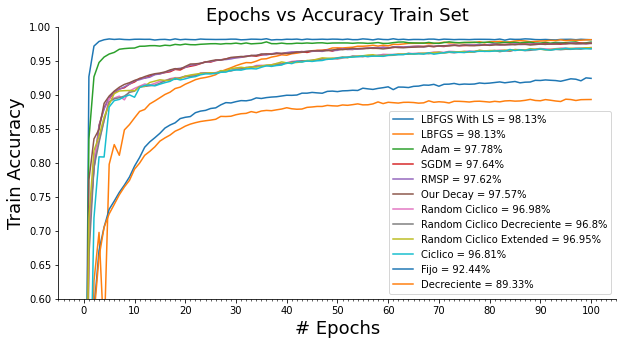

In [191]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'val_acc_list'])),
        resultados_df.loc[k1,'val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = round(resultados_df.loc[k1,'val_acc_list'][-1] * 100 , 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0.6, 1])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Train Accuracy', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

### Curvas de aprendizaje: pérdida en la función de costo

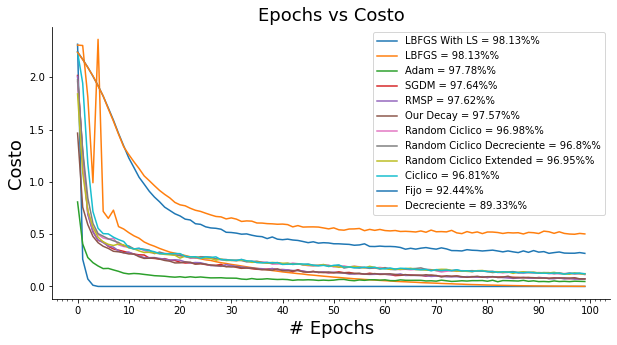

In [192]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'cost'])),
        resultados_df.loc[k1,'cost'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = resultados_df.loc[k1,'val_acc']))

plt.title('Epochs vs Costo', fontsize = 18)


ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

In [193]:
from datetime import datetime
import os.path

#Get time
now = datetime.now()
#Format DateTime
date_time = now.strftime("%m_%d_%Y-%H_%M")

#Create Path for save Results
file_name = os.path.join('Results', f'Experimento1[{date_time}].xlsx')

resultados_df.to_excel(file_name, index = False)